## __```Model schema representation:```__

```python
                                    Forward Propagation (w & b)
          +----------->------------->---------->----------->----------------------------+
          |                                                                             | 1 if p > 0.5 else 0           
INPUT(X*WEIGHT)---> LINEAR (Z=X.T*WEIGHT+BIAS)---->ACTIVATION(SIGMOID(Z))-----> OUTPUT( Y[ idx([p, 1 - p]) ] )
                     |                                                                  |                
                     +-------------<-----------------------<-------------------<--------+
                                    Backward Propagation (dw & db)

```

###

### __```Python libraries useful```__
> * numpy
> * pandas 
> * matplotlib
> * seaborn
> * sklearn
> * skimage
> * PIL
> * requests 
> * io

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns 
from skimage.transform import resize

### __```External Python libraries```__

In [2]:
from utils import generate_inputs_test as gen, adam, initialize_adam
from utils import load_dataset 

### __```Intilalize function```__
__This function is used to initialize__
```python
   weihgt  = np.zeros((ny, nx))
   bias    = np.zeros((ny, 1))
```
> 1. *nx is the features of X (X.shape = (nx, m))*
> 2. *random_init is used here to initialize weight as :*
```python 
   np.random.randn(ny, nx) * 0.01
```
> 3. *seed is a random state*

__The output is a python dictionary that contains weight and bias__

```python
   parmas = params_init(nx=4, seed = 1, random_init=False)
```


In [3]:
def params_init(nx : int, seed : int = None, random_init : bool=False, alpha : float = 0.01):

    # generate the sample random numbers 
    if seed : np.random.seed(seed=seed)
    # initializing params as python dictionary 
    params = {}

    # creating weight and bias for one neuron
    # as we said to the README file we just have one neuron (binary classification)
    ny = 1
    for i in range(ny):
        if random_init : 
            params[f'W{i+1}'] = np.random.randn(1, nx) * alpha
        else:
            params[f'W{i+1}'] = np.zeros((1, nx))
        params[f'b{i+1}'] = np.zeros((1, 1))

    # returning the output as a dictionary
    return params 

### __```Implementing sigmoid function```__

__This function takes one argument (numpy array) and return numpy array probabilities__

```python
x = np.array([1, 1])
s = sigmoid(x=x)

s = [0.73105858 0.73105858]
```

In [4]:
def sigmoid(x : np.ndarray):
    # computing sigmoid function for a given value x 

    sig = 1. / (1 + np.exp(-x))

    return sig 

### __```Forward propagation implementation```__

To implement the forward propagation witch means compute **weight(w) & bias(b)** we need the initial values of w and b \
contain in params and the values of the input matrix X that contains the features

```python
1. X.shape = (nx, m)---> (nx = features size, m = samples size)
2. params.keys() = ['W1', 'b1']
3. layer = 1 ---> one neuron

# linearity 
Z[layer] = params[f"W{layer}"].dot(X) + params[f'b{layer}']
# probabilities
A[layer] = sigmoid(x=Z[layer])

Z[layer].shape = (ny, m)
A[layer].shape = (ny, m)
```

In [5]:
def forward_propagation(X : np.ndarray, params : dict):
    # layers 
    layers = len(list(params.keys())) // 2

    # linearity & prediction 
    # Z = W.dot(X) + b
    # A = sigmoid(Z)
    Z, A = {},{}
  
    for layer in range(layers):
        # linearity
        Z[layer+1] = params[f"W{layer+1}"].dot(X) + params[f'b{layer+1}']
        # prediction
        A[layer+1] = sigmoid(x=Z[layer+1])
    
    cache = {"Z" : Z, "A" : A}

    return A[layers], cache 

### __```Cost function implemenation```__

To compute the cost function we need :

> * the last value of activation function called A_last 
> * the true target values Y
> * the Lambda value for regualazization 

__Note that Lambda is used to reduice overfiting on training set.__

To the end of this notebook we'll see how Lambda can change the result

```python

loss    = ( Y * np.log(A_last) ) + (1 - Y) * np.log(1 - A_last)
cost    = -(1. / m) * ( loss ).sum(axis=1)

```

In [6]:
def cost_function(A_last : np.ndarray, Y: np.ndarray, Lambda : float = 0, params : dict = {}):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    * A -- The activation output of the last layer, of shape (sy, m)
    * Y -- "true" labels vector of shape (ny, m)

    in the case of binary classification ny = 1
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    A.shape = 
    Y.shape = (1, ny)

    if Lambda is not null ---> regularisayion effect is apply with a factor of (Lambda / (2 * m))

    cost = cost_without_reg + regularisation_l2 

    regularisation_l2 = np.array([np.sum(np.square(params[f'W{i+1}'])) for i in range(layers)] ).sum()

    """
    
    # samples
    m       = Y.shape[1] 
    # loss function (cross-entropy)
    loss    = ( Y * np.log(A_last) ) + (1 - Y) * np.log(1 - A_last)
    # cost function
    cost    = -(1. / m) * ( loss ).sum(axis=1)
    
    if Lambda == 0: pass 
    else:
        # layer size 
        layers  = len(list(params.keys())) //  2
        # l2 compotent evaluation
        factor1 = (Lambda * 1) / (2. * m)
        factor2 = np.array( [np.sum(np.square(params[f'W{i+1}'])) for i in range(layers)] ).sum()
        # final exprssion
        regularisation_l2 = factor1 * factor2 
        cost = cost + regularisation_l2

    # np.squeeze(cost) --> np.squeeze([[1]]) = 1.0
    cost    = float(np.squeeze(cost))   
                                    
    return cost

### __```Backward propagation implementation```__

As we said [here](https://github.com/amiehe-essomba/logisticRegression/blob/computer-vision/README.md) We just need to compute two equations to solve back propagation. To do that we need :

> * params wich is a python dictionary containing **weight** and **bias** 
> * cache is a python dictionary containing **activation function** and **linearity**
> * the features matrix X 
> * the true target Y
> * and also the Lambda value as explained un **cost computation**

In [7]:
def backward_propagation(
        params  : dict, 
        cache   : dict, 
        X       : np.ndarray, 
        Y       : np.ndarray,
        Lamdba  : float = 0.0
        ):
    
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    params -- python dictionary containing our parameters 
    cache -- a dictionary containing A, and Z (activations and linear calculations).
    X -- input data of shape (nx, number of examples)
    Y -- "true" labels vector of shape (ny, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    # nomber of sample 
    m       = X.shape[1]
    # intialize gradient 
    grads   = {}
    # restoring activation & linearity from cache 
    A, Z    = cache['A'], cache['Z']  
    # computing the number of layers 
    layers  = len(list(params.keys())) // 2

    # updating gradient 
    # dZ = A[layers] - Y
    grads[f'dZ{layers}'] = A[layers] - Y
    # dW = dZ.dot(X.T)
    grads[f'dW{layers}'] = grads[f'dZ{layers}'].dot(X.T) * (1. / m)  +  (Lamdba / m) * params[f'W{layers}']
    # db = 1
    grads[f'db{layers}'] = grads[f'dZ{layers}'].mean(axis=1, keepdims=True)

    return grads 

### __```Clip implementetaion(Optional)```__

This implementation is used to avoid gradient exploding or gradient vanishing. When the gradient is computed 
some values of gradient can be very high allowing the gradient exploding. So to avoid that we can fix the border limits 
of gradient:

```python
if grads > -L : grads = -L
if grads > L  : grads = L
```

With this approche we can help gradient to converge to the global minimum. L here is à float number 

In [8]:
def clip(gradients : dict = {}, maxValue : float = 10):

    """
    clip funsion is ued to solve the issue of exploding gradient.
    by fixing the border limits the gradient cannot exceded we can solve that problem 

    * firstly we start by defining the border limits [-L, L]
    if the value of gardient id outside of this range we put it inside like this 
        - if grad > L  ---> grad = L
        - if grad < -L ---> grad = L
        - else grad = pass

    * so to make it possible we need the value of L in this case L = maxValues argument

    """
    
    for key, value in gradients.items():
        np.clip(a=value, a_min=-maxValue, a_max=maxValue, out=value)

        gradients[key] = value

    return gradients

### __```How logistic prediction works ?```__

To make prediction we need some values :
> * the params 
> * features matrix X (X_test, X_train or X_dev)

We use the A_last to compute the linearity

```python
Z           = A_last.dot(X) + params[f'b1']
predictions = sigmoid(Z)
y_pred      = np.zeros((ny, m)), with ny = 1

for i in range(m):
    if predictions[i] >= 0.5 : y_pred[0, i] = 1
    else: y_pred[0, i] = 0
```

Now you know how to implement the predction using sigmoid function 

In [9]:
def prediction(params, X, as_bool : bool = True):
    # layers 
    layers = len(list(params.keys())) // 2
    W = params[f"W{layers}"]
    b = params[f"b{layers}"]
    Z = W.dot(X) + b
    
    # prediction
    y_pred = sigmoid(x=Z)
    m = y_pred.shape[1]
    prediction = np.zeros((1, m))

    for j in range(m):
        if y_pred[0, j] >= 0.5 : prediction[0, j] = 1
        else: prediction[0, j] = 0
    
    return prediction

### __```Metric evaluation```__

To evaluate the performance of our model we can compute the accuracy of the model as follow:

```python
accuracy = 1 -  np.mean(np.abs(y_pred - y_true)) 
```

> * y_pred is the value obtained by the prediction() function 
> * y_true is the true target 

In [10]:
def scoring(y_true : np.ndarray, y_pred : np.ndarray):
    s = 1. - np.mean(np.abs(y_pred - y_true)) 
    return s

### __```Updating paramters```__

After computing the gradient we have to update **weight** and **bias** using the learning rate. So to do that we need :
> * grads which is a python dictionary containing (dW, & db)
> * params -- python dictionay containing (w & b)
> * learning_rate is a float number (learing_rate > 0)

```python
W = W - learning_rate * dW 
b = b - learning_rate * db
```

In [11]:
def updating_params(grads : dict, params : dict, learning_rate : float = 0.01):

    # number of layers
    layers = len( list(params.keys()) ) // 2

    # updating the weight and bias using the gradient (stochastic gradient descend)
    for layer in range(layers):
        params[f'W{layer+1}'] = params[f'W{layer+1}'] - learning_rate * grads[f'dW{layer+1}']
        params[f'b{layer+1}'] = params[f'b{layer+1}'] - learning_rate * grads[f'db{layer+1}']

    # returning the updating weight and bias 

    return params

### __```Now we can build our Stochastic LogisticRegression```__

> 1. initialize W & b using the features matrix X and target Y (nx = X.shape[0], ny = Y.shape[0])
> 2. propagate W & b using forward_propagation() function
> 3. compute cost using cost_function() function
> 4. compute gradient by propagating dW and db using backward_propagation() function 
> 5. using clip to put the gradient in the right side 
> 6. updatating W  & b using updating_params() function
> 7. predictions 
> 8. compute the metric (accuracy)
> 9. visulize your result
> 10. improve your model

10 steps to build your logistic regression model

In [12]:
def LogisticRegression(
        X : np.ndarray,
        Y : np.ndarray,
        validation_data     : tuple = None,
        maxValue            : float = None,
        early_stoping       : int   = 10000,
        learning_rate       : float = 1e-3,
        print_val           : bool  = True,
        epsilon             : float = 1e-8,
        verbose             : bool  = True,
        step                : int   = 100, 
        seed                : int   = None,
        random_init         : bool  = False,
        alpha               : float = 0.01,
        Lambda              : float = 0.0
       ):

    nx      = X.shape[0]
    params  = params_init(nx=nx, seed=seed, random_init=random_init, alpha=alpha)

    history = {"cost" : [], "accuracy" : [], 'val_accuracy' : []}
    
    i = 0
  
    while True:
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache"
        A_last, cache = forward_propagation(X=X, params=params.copy())
        
        # Cost function. Inputs: "A2, Y". Outputs: "cost".
        # cost = ...
        cost = cost_function(A_last=A_last, Y=Y, params=params, Lambda=Lambda)
        
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(params=params, cache=cache, X=X, Y=Y, Lamdba=Lambda)
        
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        if maxValue : grads = clip(gradients=grads, maxValue=maxValue)

        params = updating_params(params=params.copy(), grads=grads.copy(), learning_rate=learning_rate)
           
        #if validation_data:
        #    x_test, y_test  = validation_data
        #    y_pred_test     = prediction(params=params.copy(), X=x_test, as_bool=True)

        #y_pred      = prediction(params=params.copy(), X=X, as_bool=True)
        #accuracy    = scoring(y_true=Y, y_pred=y_pred)
        
        # Print the cost every 1000 iterations

        if verbose and i % step == 0:        
            if i == 0 : pass 
            else:
                if history['cost']:
                    if np.abs(history['cost'][-1] - cost) <  epsilon: 
                        print("loop break due np.abs( cost[i] - cost[i-1]) < epsilon")
                        break
                    else: pass
                else: pass 

            #if validation_data: 
            #    val_accuracy    = scoring(y_true=y_test, y_pred=y_pred_test)
            #    history['val_accuracy'].append(val_accuracy)

            history['cost'].append(cost)
            #history['accuracy'].append(accuracy)

            if print_val : 
                if validation_data : print ("epoch: %i cost: %f" %(i, cost))# accuracy, val_accuracy))
                else:  print ("epoch: %i cost: %f scoring: %f" %(i, cost))#, accuracy))
        else: pass 
        
        i += 1 
        if early_stoping:
            if i >= early_stoping: 
                print("loop break due to early stoping parameter")
                break 
            else: pass 
        else: pass
        
    print(f"\nscore train: {round(scoring(y_pred=prediction(params=params, X=X), y_true=Y), 4)}")
    print(f"\nscore test : {round( scoring(y_pred=prediction(params=params, X=validation_data[0]), y_true=validation_data[1]), 4)}")
        
    return history, params

In [13]:
x_train, y_train, x_test, y_test, classes = load_dataset()

In [14]:
shape_1 = x_train.shape
shape_2 = x_test.shape 
shape_1, shape_2

((209, 64, 64, 3), (50, 64, 64, 3))

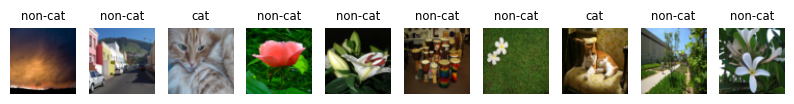

In [15]:
n_imgaes = 10
fig, axes = plt.subplots(1, n_imgaes, figsize=(n_imgaes, 1))

for i in range(n_imgaes):
    axes[i].axis("off")
    axes[i].imshow(x_train[i])
    axes[i].set_title(f"{classes[y_train[:, i][0]].decode()}", fontsize="small")
plt.show()


In [16]:
X_train = x_train.reshape((-1, shape_1[0])) / 255.
X_test  = x_test.reshape((-1, shape_2[0])) / 255.
X_train.shape, X_test.shape

((12288, 209), (12288, 50))

In [17]:
X_train.max()

1.0

In [18]:
history, params = LogisticRegression(X=X_train, Y=y_train, print_val=True, learning_rate=0.005, alpha=0.01, Lambda=0.2,
                step=10000, early_stoping=100000, epsilon=1e-8, validation_data=(X_test, y_test), random_init=True)

C:\Users\amib\AppData\Local\Temp\ipykernel_14560\545139742.py:27: RuntimeWarning: divide by zero encountered in log
  loss    = ( Y * np.log(A_last) ) + (1 - Y) * np.log(1 - A_last)
C:\Users\amib\AppData\Local\Temp\ipykernel_14560\545139742.py:27: RuntimeWarning: invalid value encountered in multiply
  loss    = ( Y * np.log(A_last) ) + (1 - Y) * np.log(1 - A_last)


epoch: 0 cost: nan


epoch: 10000 cost: 3.774302
epoch: 20000 cost: 2.706738
epoch: 30000 cost: 1.967235
epoch: 40000 cost: 1.442399
epoch: 50000 cost: 1.068093
epoch: 60000 cost: 0.800731
epoch: 70000 cost: 0.609637
epoch: 80000 cost: 0.473014
epoch: 90000 cost: 0.375318
loop break due to early stoping parameter

score train: 1.0

score test : 0.42


In [19]:
prediction(params=params, X=X_test)

array([[0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [23]:
y_pred_train = prediction(params=params, X=X_train)
y_pred_test = prediction(params=params, X=X_test)

Cm = cm(y_pred=y_pred_test.reshape((-1,)), y_true=y_test.reshape((-1,)))
y_pred_test

print(f"scoring : {round( scoring(y_test, y_pred_test), 4)}")
print(Cm)

scoring : 0.42
[[17  0]
 [29  4]]


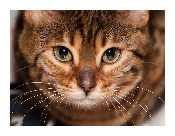

response time : 0.3101s


In [21]:
from utils import url_img_read

img_path = "https://www.sciencesetavenir.fr/assets/img/2017/03/29/cover-r4x3w1000-58dbbd655242b-capture-d-e-cran-2017-03-29-a-15-55-40.png"
img = url_img_read(url=img_path,show_img=True)

In [22]:
img_resize  = resize(img, output_shape=(64, 64, 3))
print(img_resize.shape)
img = img_resize.reshape((-1, 1))
print(img.shape)

y_pred = int( np.squeeze(prediction(params=params, X=img)) )
print(y_pred)
print(classes[y_pred].decode())

(64, 64, 3)
(12288, 1)
0
non-cat
